In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as so
import scipy.stats as ss
import statsmodels.api as sm
import random
import copy
import json

from tqdm import tqdm 

# Import data

In [49]:
scoot_filename = "../data/input/scootN00_002e1.csv"
scoot = pd.read_csv(scoot_filename)

# Process data

In [50]:
scoot = scoot.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
scoot['measurement_end_utc'] = pd.to_datetime(scoot.measurement_end_utc)
scoot['hour'] = scoot.measurement_end_utc.apply(lambda x: x.hour)
scoot['n_vehicles_in_interval_norm'] = scoot.n_vehicles_in_interval.apply(lambda x: (x)/scoot.n_vehicles_in_interval.std() ) 
scoot['saturation_norm'] = scoot.saturation.apply(lambda x: (x)/scoot.saturation.std() ) 
scoot['occupancy_percentage_norm'] = scoot.saturation.apply(lambda x: (x)/scoot.occupancy_percentage.std() ) 

In [51]:
rho = scoot.sort_values('occupancy_percentage_norm').occupancy_percentage_norm.values
q = scoot.sort_values('occupancy_percentage_norm').n_vehicles_in_interval_norm.values
saturation = scoot.sort_values('occupancy_percentage_norm').saturation.values
log_q = np.log(q).reshape((len(q),1))
    
def exponential_fd(p):
    return p[0]*rho*np.exp(-p[1]*rho)
def log_exponential_fd(p):
    return np.log(p[0]) + np.log(rho) - p[1]*rho
def exponential_fd_jacobian(p):
    _a = p[0]
    _b = p[1]
    return _a*np.exp(-_b*rho)*(1-_b*rho)

# Visualise data

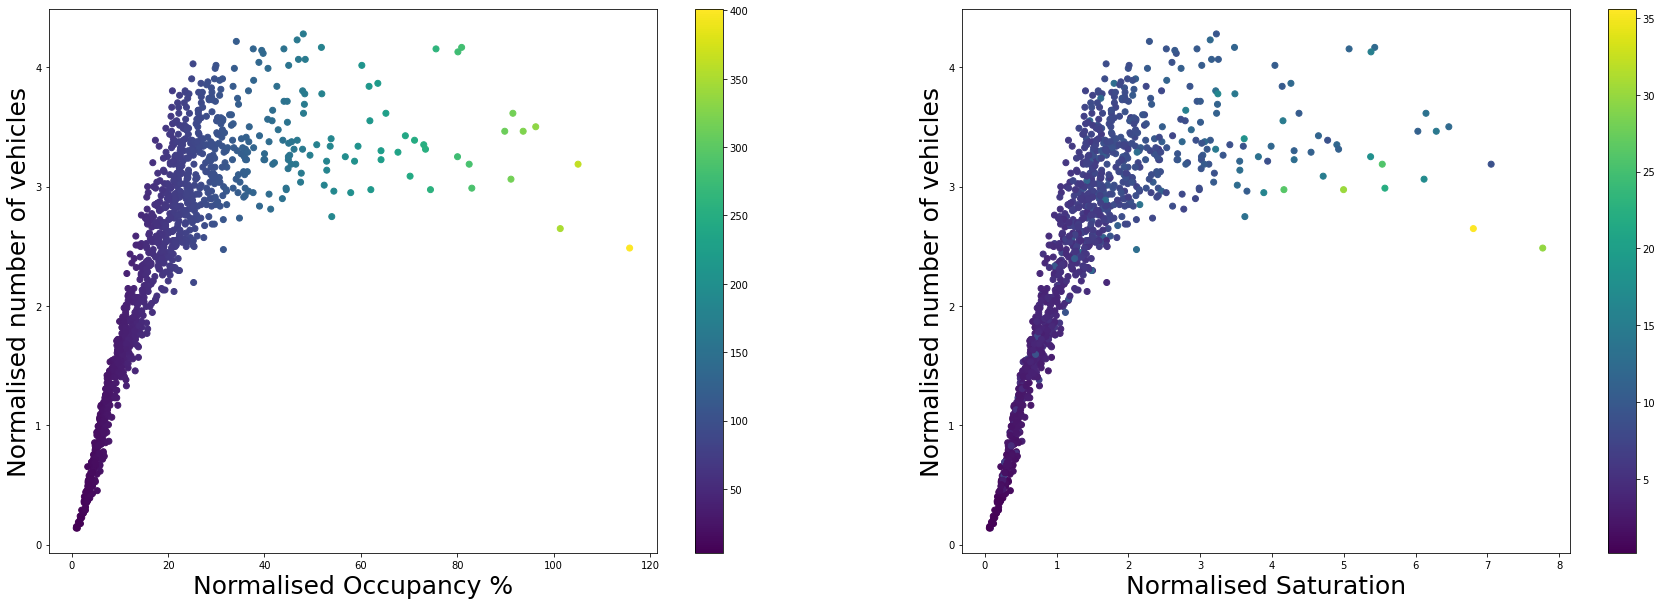

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(30,10))

plt.subplot(1,2,1)
plt.scatter(y=scoot.n_vehicles_in_interval_norm,x=scoot.occupancy_percentage_norm,c=scoot.saturation)
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Occupancy %',fontsize=25)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y=scoot.n_vehicles_in_interval_norm,x=scoot.saturation_norm,c=scoot.occupancy_percentage)
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Saturation',fontsize=25)
plt.colorbar()

### Try a few noise models

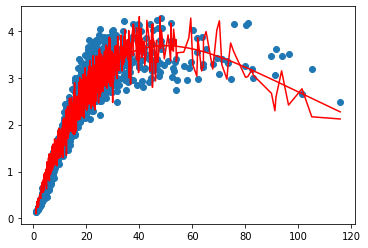

In [1058]:
sigma2_guess = 0.3
power = 1
y_fit = exponential_fd([alpha_least_squares,beta_least_squares])
y_noisy_fit = y_fit + np.random.multivariate_normal(np.zeros(len(rho)),np.diag((rho/np.max(rho))**power)*sigma2_guess)

# plt.plot(rho/np.max(rho)*sigma2_guess,q)
plt.scatter(rho,q)
plt.plot(rho,y_fit,color='red')
plt.plot(rho,y_noisy_fit,color='red')

Text(0, 0.5, 'Observation $\\sigma^2$')

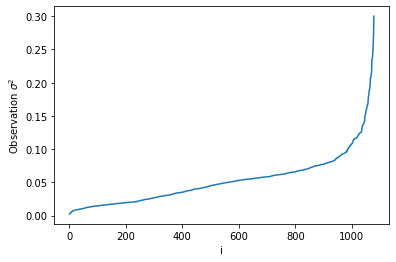

In [1059]:
plt.plot(range(1,len(rho)+1),rho/np.max(rho)*sigma2_guess)
plt.xlabel('i')
plt.ylabel(r'Observation $\sigma^2$')

# Parameter estimation via Marginal Likelihood Estimation

We employ three models



We look at [this paper](https://www.sciencedirect.com/science/article/pii/S0167947309002722) and implement a population MCMC for marginal likelihood estimation.

In [1060]:
# Parameter values
alpha_least_squares = 0.20134168602010902
beta_least_squares = 0.020107293622744736

# Estimated q_hat based on deterministic rho
q_hat_least_squares = log_exponential_fd([alpha_least_squares,beta_least_squares])

## Vanilla Metropolis Hastings 

In [1061]:
# Define base URL
base_url = '../data/output/models/scootN00_002e1/exponential_fd/'
# Define inference method
method = 'grwmh_mcmc'

In [1062]:
def grw_mcmc(log_target, kernel, _p0, _y, _K, _N, _beta,seed=None,print_stat:bool=False):
    """ Gaussian Random Walk Metropolis Hastings MCMC method for sampling from pdf defined by log_prior and log_likelihood.
    Inputs:
        log_likelihood - log-likelihood function
        _p0 - initial sample
        _y - observed data
        _sigma2 - prior variance
        _N - number of samples
        _beta - step-size parameter
    Returns:
        _theta - samples from target distribution
        acc/n_iters - the proportion of accepted samples"""

    _theta = []
    acc = 0
    p_prev = copy.deepcopy(_p0)
    print('p0',p_prev)
    _n0 = p_prev.shape[0]
    
    for i in tqdm(range(_N)):
        
        # Evaluate log 
        lt_prev = log_target(p_prev, _y)

        # Propose new sample using GRW proposal
        p_new = kernel(p_prev,_beta,_K)
        
        lt_new = log_target(p_new, _y)
        
        if print_stat or i in [int(j/10*_N) for j in range(1,11)]:
            print('p_prev',p_prev,'lt_prev',lt_prev)
            print('p_new',p_new,'lt_new',lt_new)
            print(f'Acceptance rate {int(100*acc / _N)}%')
        
        # TODO: Calculate GRW acceptance probability
        log_acc = lt_new - lt_prev
        log_u = np.log(np.random.random())
        

        # Accept/Reject
        # TCompare log_alpha and log_u to accept/reject sample
        if min(np.exp(log_acc),1) >= np.exp(log_u):
            acc += 1
            _theta.append(p_new)
            p_prev = p_new
        else:
            _theta.append(p_prev)

    return np.array(_theta), acc / _N


### Some key functions

In [1063]:
def beta_distribution_var(a,b):
    return a*b / ((a+b)**2*(a+b+1))
def gamma_distribution_var(a,b):
    return a/(b**2)

In [1118]:
# Fix random seed
np.random.seed(2021)
# Define number of parameters
num_params = 3
# Define parameter names
param_names = [r'$\alpha$',r'$\beta$',r'$\sigma$']
# Flag for initiliasing parameters by randomly sampling from priors (except for noise sigma2)
# If True it initialises parameters on OLS solution (except for noise sigma2)
random_initialisation = True

# Define true sigma (used to load the true posterior)
sigma2 = 2

# Define filename
# filename = f'grw_parameter_posterior_fixed_sigma2_{int(sigma2)}'
filename = f'grw_parameter_posterior_learned_sigma2'
# filename = f'grw_parameter_posterior_learned_sigma2_heteroskedasticity'

# Flag for loading data
load_data = False

if not load_data:
    # Define number of iterations of each temperature chain
    N = 1000
    # Define beta step
    beta_step = 0.05
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    beta_prior_a_alpha_param = 1.
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    beta_prior_a_beta_param = 1.
    # Prior beta hyperparameter for Beta prior of alpha parameter
    beta_prior_b_alpha_param = 5.
    # Prior beta hyperparameter for Beta prior of beta parameter
    beta_prior_b_beta_param = 3.
    # Prior alpha hypeparameter for Gamma prior of observation noise parameter
    gamma_prior_a_sigma_param = 40.
    # Prior beta hypeparameter for amma prior of observation noise parameter
    gamma_prior_b_sigma_param = 3.5/gamma_prior_a_sigma_param
    # Define parameter prior covariance
    prior_covariance = np.diag([beta_distribution_var(beta_prior_a_alpha_param,beta_prior_b_alpha_param),
                                beta_distribution_var(beta_prior_a_beta_param,beta_prior_b_beta_param),
                                gamma_distribution_var(gamma_prior_a_sigma_param,1./gamma_prior_b_sigma_param)]) 
                              #0])
                            #gamma_distribution_var(gamma_prior_a_sigma_param,gamma_prior_b_sigma_param)])

    # Generate pairs of (alpha,beta) from Beta(1,2) prior
    parameters_init = np.zeros(num_params)
    if random_initialisation:
        parameters_init[0] = np.random.beta(beta_prior_a_alpha_param,beta_prior_b_alpha_param,1)
        parameters_init[1] = np.random.beta(beta_prior_a_beta_param,beta_prior_b_beta_param,1)
        # Gamma prior for unknown observation noise
        parameters_init[2] = np.random.gamma(shape=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param,size=1) #sigma2
    else:
        parameters_init[0] = alpha_least_squares
        parameters_init[1] = beta_least_squares
        parameters_init[2] = 0.6
        
else:
    # Load metadata
    with open(base_url+method+'/'+filename+'_metadata.json') as json_file:
        grw_posterior_metadata = json.load(json_file)
    
    
    # Define number of iterations of each temperature chain
    N = grw_posterior_metadata['N']
    # Define beta step
    beta_step = grw_posterior_metadata['beta_step']
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    beta_prior_a_alpha_param = grw_posterior_metadata['beta_prior_alpha_param']['a']
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    beta_prior_a_beta_param = grw_posterior_metadata['beta_prior_beta_param']['a']
    # Prior beta hyperparameter for Beta prior of alpha parameter
    beta_prior_b_alpha_param = grw_posterior_metadata['beta_prior_alpha_param']['b']
    # Prior beta hyperparameter for Beta prior of beta parameter
    beta_prior_b_beta_param = grw_posterior_metadata['beta_prior_beta_param']['b']
    if len(grw_posterior_metadata['gamma_prior_sigma_param'].keys()) == 2:
        # Prior alpha hypeparameter for Gamma prior of observation noise parameter
        gamma_prior_a_sigma_param = grw_posterior_metadata['gamma_prior_sigma_param']['a']
        # Prior beta hypeparameter for Gamma prior of observation noise parameter
        gamma_prior_b_sigma_param = grw_posterior_metadata['gamma_prior_sigma_param']['b']
    # Define parameter prior covariance
    prior_covariance = np.diag(grw_posterior_metadata['prior_variances'])
    # Generate pairs of (alpha,beta) from Beta(1,2) prior
    parameters_init = grw_posterior_metadata['initial_parameters']
    
    
print('Parameter prior covariance')
print(prior_covariance)

print(fr'Initial alpha={parameters_init[0]}, beta={parameters_init[1]}, sigma^2={parameters_init[2]}')

Parameter prior covariance
[[0.01984127 0.         0.        ]
 [0.         0.0375     0.        ]
 [0.         0.         0.30625   ]]
Initial alpha=0.21533511674992067, beta=0.6330222085853617, sigma^2=3.786270621863122


#### Prior visualisation

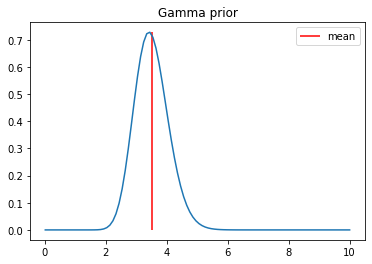

In [1129]:
x1 = np.linspace(0.01,10,100)
y1 = ss.gamma.pdf(x1,a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)
plt.plot(x1,y1)
plt.vlines(gamma_prior_a_sigma_param*gamma_prior_b_sigma_param,ymin=0,ymax=np.max(y1[~np.isnan(y1)]),color='red',label='mean')
plt.title('Gamma prior')
plt.legend()
plt.show()

### Define key functions

In [1130]:
# Vanilla Metropolis Hastings MCMC
def exponential_fd_log_prior(p):
    return ss.beta.logpdf(p[0],beta_prior_a_alpha_param,beta_prior_b_alpha_param)\
            + ss.beta.logpdf(p[1],beta_prior_a_beta_param,beta_prior_b_beta_param)\
            + ss.gamma.logpdf(p[2],a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)

def exponential_fd_log_likelihood(p,y):
    return ss.multivariate_normal.logpdf(y,exponential_fd(p[:-1]),np.eye(y.shape[0])*p[-1])

def exponential_fd_log_heteroskedastic_likelihood(p,y):
    return ss.multivariate_normal.logpdf(y,exponential_fd(p[:-1]),np.diag(rho/np.max(rho))*p[-1])
def exponential_fd_log_target(p,y):
    # Log target is sum of priors and likelihood for each temperature
    return exponential_fd_log_prior(p) + exponential_fd_log_likelihood(p,y)

def exponential_fd_log_heteroskedastic_target(p,y):
    # Log target is sum of priors and likelihood for each temperature
    return exponential_fd_log_prior(p) + exponential_fd_log_heteroskedastic_likelihood(p,y)


def gaussian_transition_kernel(p_prev,_beta,_cov):
    # Propose move
    p_new = p_prev + _beta*np.random.multivariate_normal(np.zeros(p_prev.shape[0]),_cov)
    
    # Reflect off boundaries
    for j in range(num_params):
        if p_new[j] < 0.:
            p_new[j] = -p_new[j]
        if p_new[j] > 1. and j != (num_params-1):
            p_new[j] = 1. - (p_new[j] - 1.)
        if p_new[num_params-1] > 4.:
            p_new[j] = 4. - (p_new[j] - 4.)
    return p_new

### Plot heteroskedastic likelihood

In [1131]:
# sigma2s_discete = np.linspace(0.4,1,1000)
# heteroskedastic_log_likelihood = np.array([exponential_fd_log_heteroskedastic_likelihood([alpha_least_squares,beta_least_squares,sigma2s_discete[i]],q) for i in range(1000)])
# sigma2s_argmax = sigma2s_discete[np.argmax(heteroskedastic_log_likelihood)]
# print(f'MLE of heteroskedastic likelihood = {sigma2s_argmax}')

In [1132]:
# plt.scatter(sigma2s_discete,heteroskedastic_log_likelihood)
# plt.xlabel(r'$\sigma^2$')
# plt.ylabel(r'Heteroskedastic log-likelihood')

### True unnormalised parameter posterior (based on target)

In [1133]:
load_data = True

In [1134]:
if not load_data:
    # Define grid quantities
    amin = 0.01
    amax = 0.4#0.21553951534200608*2
    bmin = 0.001
    bmax = 0.4#0.020985778899829197*2
    sigma2min = 0.4
    sigma2max = 3.
    n_steps = 22
    
    if "learned_sigma2" in filename:
        a = np.linspace(amin,amax,n_steps)
        b = np.linspace(bmin,bmax,n_steps)
        sigma2s =  np.linspace(sigma2min,sigma2max,n_steps)
        # Compute unnormalised log posterior
        # log_unnormalised_posterior_value = log_exponential_fd_target_vector(A,B)
        log_unnormalised_posterior_value = []
        for _a in tqdm(a):
            for _b in b:
                for _s in sigma2s:
                    if 'heteroskedasticity' in filename:
                        log_unnormalised_posterior_value.append(exponential_fd_log_heteroskedastic_target([_a,_b,_s],q))
                    else:
                        log_unnormalised_posterior_value.append(exponential_fd_log_target([_a,_b,_s],q))
        Q_hat = np.array(log_unnormalised_posterior_value).reshape((n_steps,n_steps,n_steps))

        # Export true posterior
        if 'heteroskedasticity' in filename:
            with open((base_url+f'true_parameter_posterior_with_heteroskedastic_sigma.txt'), 'wb') as f:
                np.savetxt(f, np.column_stack(Q_hat), fmt='%1.10f')
        else:
            with open((base_url+f'true_parameter_posterior_with_sigma.txt'), 'wb') as f:
                np.savetxt(f, np.column_stack(Q_hat), fmt='%1.10f')
        np.savetxt(base_url+'rho.txt',rho)
        np.savetxt(base_url+'q.txt',q)

        true_posterior_metadata = {}
        true_posterior_metadata['n_steps'] = n_steps
        true_posterior_metadata['amin'] = amin
        true_posterior_metadata['amax'] = amax
        true_posterior_metadata['bmin'] = bmin
        true_posterior_metadata['bmax'] = bmax
        true_posterior_metadata['sigma2min'] = sigma2min
        true_posterior_metadata['sigma2max'] = sigma2max

        # print(json.dumps(metadata, indent=2))
        if 'heteroskedasticity' in filename:
            with open(base_url+f'true_parameter_posterior_with_heteroskedastic_sigma_metadata.json', 'w') as outfile:
                json.dump(true_posterior_metadata, outfile)
        else:
            with open(base_url+f'true_parameter_posterior_with_sigma_metadata.json', 'w') as outfile:
                json.dump(true_posterior_metadata, outfile)
    else:
        a = np.linspace(amin,amax,n_steps)
        b = np.linspace(bmin,bmax,n_steps)
        # Create mesh
        B,A = np.meshgrid(b,a)
        # Compute unnormalised log posterior
        # log_unnormalised_posterior_value = log_exponential_fd_target_vector(A,B)
        log_unnormalised_posterior_value = []
        for _a in tqdm(a):
            for _b in b:
                log_unnormalised_posterior_value.append(exponential_fd_log_target([_a,_b,float(sigma2)],q))
        Q_hat = np.array(log_unnormalised_posterior_value).reshape((n_steps,n_steps))

        # Export true posterior
        np.savetxt(base_url+f'true_parameter_posterior_sigma2_{int(sigma2)}.txt',Q_hat)
        np.savetxt(base_url+'rho.txt',rho)
        np.savetxt(base_url+'q.txt',q)

        true_posterior_metadata = {}
        true_posterior_metadata['n_steps'] = n_steps
        true_posterior_metadata['amin'] = amin
        true_posterior_metadata['amax'] = amax
        true_posterior_metadata['bmin'] = bmin
        true_posterior_metadata['bmax'] = bmax

        # print(json.dumps(metadata, indent=2))

        with open(base_url+f'true_parameter_posterior_sigma2_{int(sigma2)}_metadata.json', 'w') as outfile:
            json.dump(true_posterior_metadata, outfile)
    
else:
    # LOAD DATA
    
    if "learned_sigma2" in filename:
        # Load true posterior
        if 'heteroskedasticity' in filename:
            with open((base_url+f'true_parameter_posterior_with_heteroskedastic_sigma.txt'), 'r') as f:
                Q_hat = np.loadtxt(f) 
        else:
            with open((base_url+f'true_parameter_posterior_with_sigma.txt'), 'r') as f:
                Q_hat = np.loadtxt(f) 
        Q_hat = Q_hat.reshape((Q_hat.shape[0],Q_hat.shape[0],Q_hat.shape[0]))
        # Load true posterior metadata
        if 'heteroskedasticity' in filename:
            with open(base_url+f'true_parameter_posterior_with_heteroskedastic_sigma.json') as json_file:
                true_posterior_metadata = json.load(json_file)
        else:
            with open(base_url+f'true_parameter_posterior_with_sigma_metadata.json') as json_file:
                true_posterior_metadata = json.load(json_file)

        # Define parameter grid 
        a = np.linspace(true_posterior_metadata['amin'],true_posterior_metadata['amax'],true_posterior_metadata['n_steps'])
        b = np.linspace(true_posterior_metadata['bmin'],true_posterior_metadata['bmax'],true_posterior_metadata['n_steps'])
        sigma2s = np.linspace(true_posterior_metadata['sigma2min'],true_posterior_metadata['sigma2max'],true_posterior_metadata['n_steps'])
        # Create mesh
        B,A = np.meshgrid(b,a)
        Sigma2,_ = np.meshgrid(sigma2s,b)

        # Store grid quantities
        amin = true_posterior_metadata['amin']
        amax = true_posterior_metadata['amax']
        bmin = true_posterior_metadata['bmin']
        bmax = true_posterior_metadata['bmax']
        sigma2min = true_posterior_metadata['sigma2min']
        sigma2max = true_posterior_metadata['sigma2max']
        n_steps = true_posterior_metadata['n_steps']
    else:
        # Load true posterior
        Q_hat = np.loadtxt(base_url+f'true_parameter_posterior_sigma2_{int(sigma2)}.txt') 
        Q_hat = Q_hat.reshape((Q_hat.shape[0],Q_hat.shape[0],Q_hat.shape[0]))
        
        # Load true posterior metadata
        with open(base_url+f'true_parameter_posterior_sigma2_{int(sigma2)}_metadata.json') as json_file:
            true_posterior_metadata = json.load(json_file)

        # Define parameter grid 
        a = np.linspace(true_posterior_metadata['amin'],true_posterior_metadata['amax'],true_posterior_metadata['n_steps'])
        b = np.linspace(true_posterior_metadata['bmin'],true_posterior_metadata['bmax'],true_posterior_metadata['n_steps'])
        # Create mesh
        B,A = np.meshgrid(b,a)

        # Store grid quantities
        amin = true_posterior_metadata['amin']
        amax = true_posterior_metadata['amax']
        bmin = true_posterior_metadata['bmin']
        bmax = true_posterior_metadata['bmax']
        n_steps = true_posterior_metadata['n_steps']

In [1135]:
load_data = False

In [1136]:
if load_data:
    grw_mcmc_parameters = np.loadtxt(base_url+method+'/'+filename+'.txt')
    grw_mcmc_acceptance = grw_posterior_metadata['acceptance']
else:
    if 'heteroskedasticity' in filename:
        grw_mcmc_parameters,grw_mcmc_acceptance = grw_mcmc(exponential_fd_log_heteroskedastic_target,
                                                            gaussian_transition_kernel,
                                                            parameters_init,
                                                            q,
                                                            prior_covariance,
                                                            N,
                                                            beta_step,
                                                            None,
                                                            False)
    else:
        grw_mcmc_parameters,grw_mcmc_acceptance = grw_mcmc(exponential_fd_log_target,
                                                            gaussian_transition_kernel,
                                                            parameters_init,
                                                            q,
                                                            prior_covariance,
                                                            N,
                                                            beta_step,
                                                            None,
                                                            False)
print('Metropolis Hastings Gaussian Random Walk MCMC')
print(f'Acceptance rate {int(grw_mcmc_acceptance*100)}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

p0 [0.21533512 0.63302221 3.78627062]


 10%|█         | 101/1000 [00:22<03:51,  3.89it/s]

p_prev [0.18595206 0.79142593 3.99833615] lt_prev -2605.1040865540026
p_new [7.80406012 7.21065183 3.98590395] lt_new -inf
Acceptance rate 3%


 20%|██        | 201/1000 [00:45<03:08,  4.24it/s]

p_prev [0.20783774 0.71437349 3.99815288] lt_prev -2604.1741434697274
p_new [7.78864438 7.28472594 3.99103456] lt_new -inf
Acceptance rate 6%


 30%|███       | 301/1000 [01:10<03:02,  3.83it/s]

p_prev [0.25450083 0.70780493 3.98793704] lt_prev -2604.918130686556
p_new [7.73028003 7.29314625 3.99311693] lt_new -inf
Acceptance rate 9%


 40%|████      | 401/1000 [01:36<02:36,  3.82it/s]

p_prev [0.29038892 0.78157128 3.96578123] lt_prev -2607.8152707181503
p_new [0.28488541 0.77327658 3.93526624] lt_new -2610.235722302006
Acceptance rate 13%


 50%|█████     | 501/1000 [02:01<02:05,  3.98it/s]

p_prev [0.33362629 0.67691463 3.99862734] lt_prev -2603.6026657634434
p_new [7.66615405 7.32595863 3.95133727] lt_new -inf
Acceptance rate 16%


 54%|█████▎    | 535/1000 [02:10<01:53,  4.09it/s]


KeyboardInterrupt: 

### Compute Gelman Rubin convergene diagnostic

In [1096]:
def gelman_rubin_statistic(posterior_samples,r_critical:float=1.1):
    # See more details here: https://pymc-devs.github.io/pymc/modelchecking.html
    # Get number of chain iterations and number of chains
    _n,_m = posterior_samples.shape
    # Compute posterior mean for each parameter dimension
    posterior_parameter_means = np.array([np.mean(posterior_samples[:,j]) for j in range(_m)])
#     print('Computing B')
    # Compute B
    _B = _n/(_m-1) * np.sum([(posterior_parameter_means[j] - np.mean(posterior_samples,axis=(0,1)))**2 for j in range(_m)])
    # Compute W
#     print('Computing W')
    _W = (1./_m) * np.sum([(1./(_n-1)* np.sum([(posterior_samples[i,j]-posterior_parameter_means[j])**2 for i in range(_n)])) for j in range(_m)])
    # Compute parameter marginal posterior variance
#     print('Computing marginal posterior variance')
    posterior_marginal_var = ((_n-1)/_n)*_W + _B/_n
    # Compute R stastic
#     print('Computing marginal posterior variance')
    r_stat = np.sqrt(posterior_marginal_var/_W)
    
    # Decide if convergence was achieved
    if r_stat < r_critical: print(r'MCMC chains have converged with $\hat{R}$=',r_stat,'!')
    else: print(r'MCMC chains have NOT converged with $\hat{R}$=',r_stat,'...')
        
    return r_stat

In [1097]:
grw_mcmc_gelman_rubin_statistic = gelman_rubin_statistic(grw_mcmc_parameters)

MCMC chains have NOT converged with $\hat{R}$= 7.994730502205773 ...


### Inspect samples 

In [1098]:
# Define burnin
burnin = 1
export_data = False

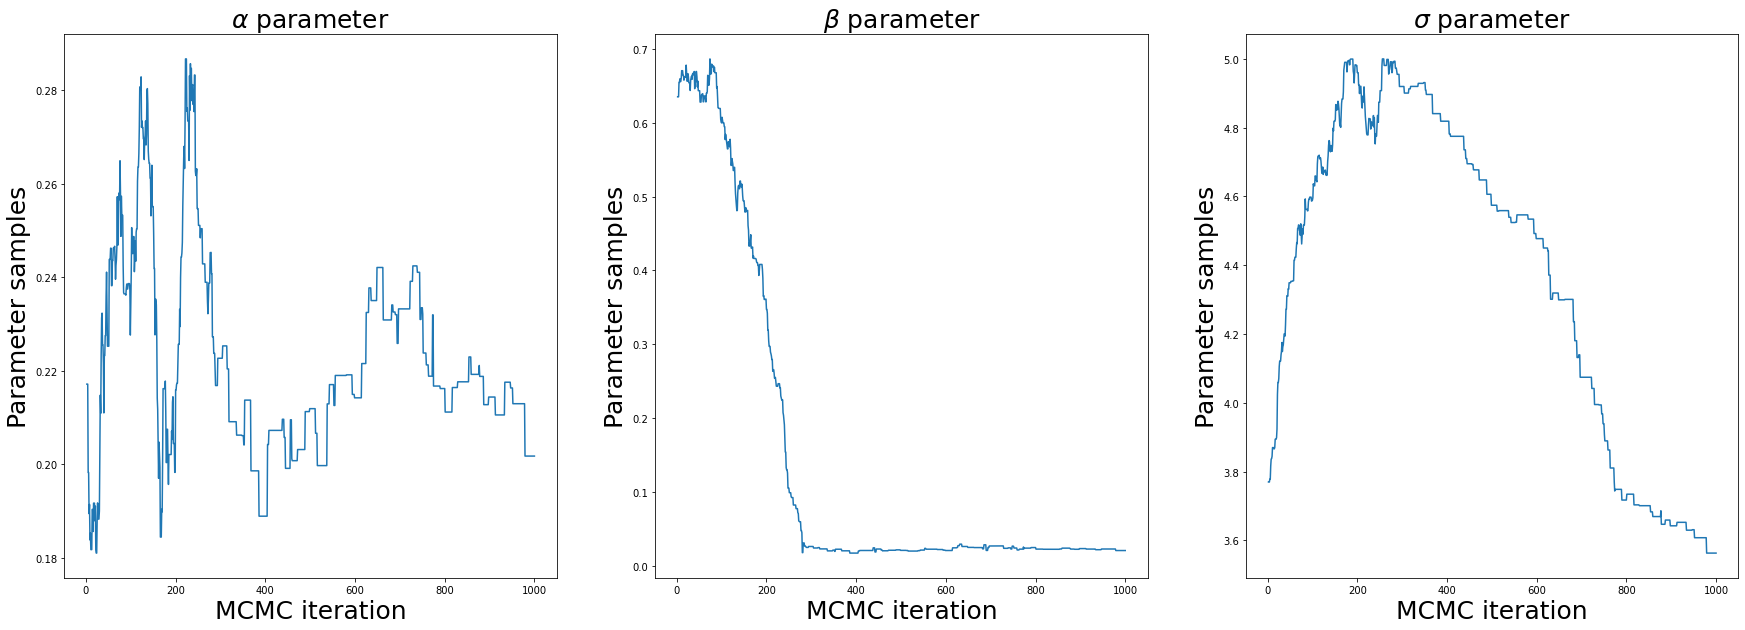

In [1099]:
fig, ax = plt.subplots(nrows=1, ncols=num_params,figsize=(30,10))

for i in range(1,num_params+1):
    plt.subplot(1,num_params,i)
    plt.title(f'{param_names[i-1]} parameter',fontsize=25)
    plt.plot(range(burnin+1,N+1),grw_mcmc_parameters[burnin:,i-1],label='Sampled chains')
    plt.ylabel('Parameter samples',fontsize=25)
    plt.xlabel('MCMC iteration',fontsize=25)

if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_mixing.png')


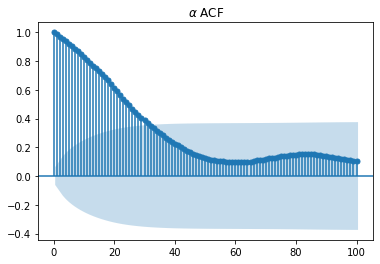

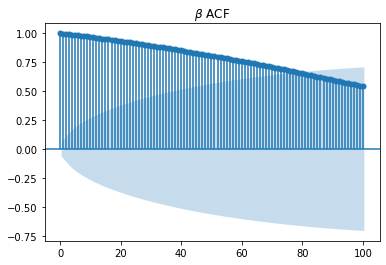

In [1100]:
# Plot autocorrelation function
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,0], lags=100,title=r'$\alpha$ ACF')
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_alpha_acf.png')
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,1], lags=100,title=r'$\beta$ ACF')
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_beta_acf.png')
plt.show()

In [1101]:
burnin = 1

Locator attempting to generate 1731 ticks ([-546300.0, ..., -27300.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1752 ticks ([-479500.0, ..., -41750.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1716 ticks ([-227600.0, ..., -56100.0]), which exceeds Locator.MAXTICKS (1000).


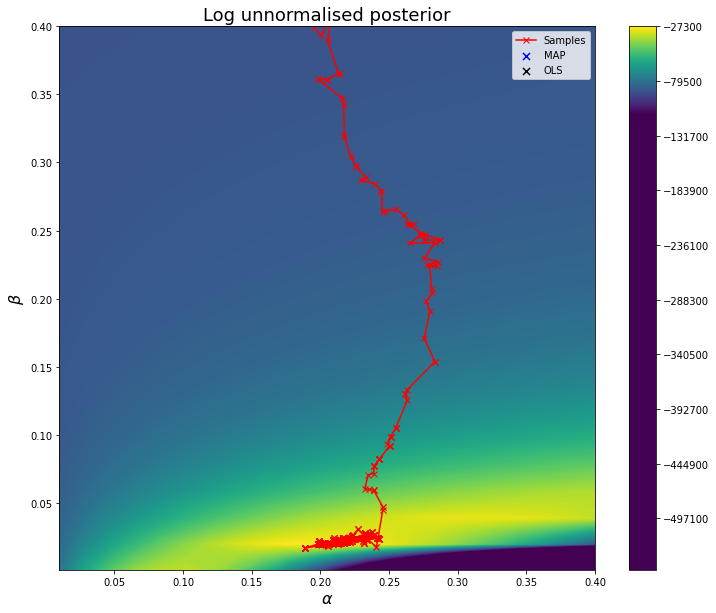

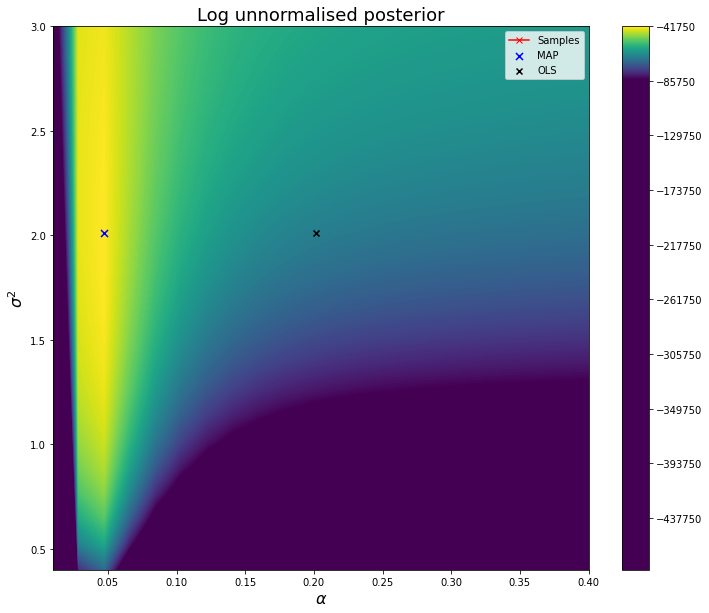

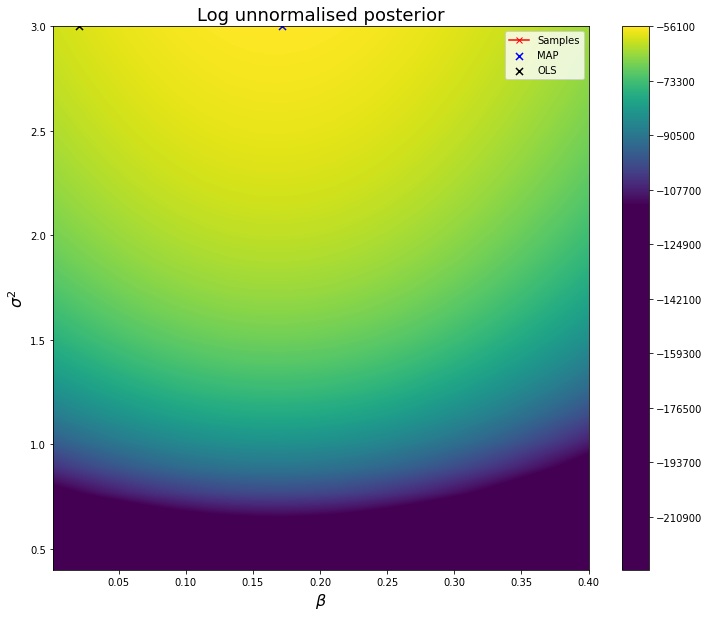

In [1116]:
plt.figure(figsize=(12,10))
# Create a contour
# B,A = np.meshgrid(b,a)
if len(Q_hat.shape) == 3:
    A,B = np.meshgrid(a,b)
    Q_hat_marginal = np.sum(Q_hat,axis=2)
    im = plt.contourf(A, B, Q_hat_marginal, 2000,vmin=np.max(Q_hat_marginal)*4,vmax=np.max(Q_hat_marginal))
else:
    im = plt.contourf(A, B, Q_hat, 2000,vmin=np.max(Q_hat)*4,vmax=np.max(Q_hat))
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot(grw_mcmc_parameters[burnin:,0],grw_mcmc_parameters[burnin:,1],label='Samples',marker='x',color='red')
if len(Q_hat.shape) == 3:
    plt.scatter(A.flatten()[np.argmax(Q_hat_marginal)],Sigma2.flatten()[np.argmax(Q_hat_marginal)],label='MAP',marker='x',s=50,color='blue')
else:
    plt.scatter(A.flatten()[np.argmax(Q_hat)],Sigma2.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=50,color='blue')
plt.scatter(alpha_least_squares,beta_least_squares,label='OLS',marker='x',s=50,color='black')
plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'$\beta$',fontsize=16)
plt.title(r'Log unnormalised posterior',fontsize=18)
plt.colorbar(im)
plt.legend()

if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_2d_mixing.png')
    
if "learned_sigma2" in filename:
    Sigma2,A = np.meshgrid(sigma2s,a)
    
    plt.figure(figsize=(12,10))
    # Create a contour
    Q_hat_marginal = np.sum(Q_hat,axis=1)
    im1 = plt.contourf(A, Sigma2, Q_hat_marginal, 2000,vmin=np.max(Q_hat_marginal)*2,vmax=np.max(Q_hat_marginal))
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(grw_mcmc_parameters[burnin:,0],grw_mcmc_parameters[burnin:,2],label='Samples',marker='x',color='red')
    plt.scatter(A.flatten()[np.argmax(Q_hat_marginal)],Sigma2.flatten()[np.argmax(Q_hat_marginal)],label='MAP',marker='x',s=50,color='blue')
    plt.scatter(alpha_least_squares,Sigma2.flatten()[np.argmax(Q_hat_marginal)],label='OLS',marker='x',color='black')
#     plt.vlines(alpha_least_squares,ymin=true_posterior_metadata['sigma2min'],ymax=true_posterior_metadata['sigma2max'],label='Least-squares estimate',color='blue')
    plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
    plt.ylim([true_posterior_metadata['sigma2min'], true_posterior_metadata['sigma2max']])
    plt.xlabel(r'$\alpha$',fontsize=16)
    plt.ylabel(r'$\sigma^2$',fontsize=16)
    plt.title(r'Log unnormalised posterior',fontsize=18)
    plt.colorbar(im1)
    plt.legend()

    if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_sigma_alpha_2d_mixing.png')
        
        
    Sigma2,B = np.meshgrid(sigma2s,b)
    
    plt.figure(figsize=(12,10))
    # Create a contour
    Q_hat_marginal = np.sum(Q_hat,axis=0) 
    im2 = plt.contourf(B, Sigma2, Q_hat_marginal, 2000,vmin=np.max(Q_hat_marginal)*2,vmax=np.max(Q_hat_marginal))
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(grw_mcmc_parameters[burnin:,1],grw_mcmc_parameters[burnin:,2],label='Samples',marker='x',color='red')
    plt.scatter(B.flatten()[np.argmax(Q_hat_marginal)],Sigma2.flatten()[np.argmax(Q_hat_marginal)],label='MAP',marker='x',s=50,color='blue')
    plt.scatter(beta_least_squares,Sigma2.flatten()[np.argmax(Q_hat_marginal)],label='OLS',marker='x',s=50,color='black')
    #     plt.vlines(beta_least_squares,ymin=true_posterior_metadata['sigma2min'],ymax=true_posterior_metadata['sigma2max'],label='Least-squares estimate',color='blue')
    plt.xlim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
    plt.ylim([true_posterior_metadata['sigma2min'], true_posterior_metadata['sigma2max']])
    plt.xlabel(r'$\beta$',fontsize=16)
    plt.ylabel(r'$\sigma^2$',fontsize=16)
    plt.title(r'Log unnormalised posterior',fontsize=18)
    plt.colorbar(im2)
    plt.legend()

    if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_sigma_beta_2d_mixing.png')

### Marginal likelihood estimation

We use the posterior harmonic mean of the likelihood values i.e.

$$Z = \left[\frac{1}{N} \sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})^{-1}\right]^{-1}$$

or equivalently

$$\log(Z) = -\log\left(-\log(N) -\sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})\right)$$

In [29]:
def log_posterior_harmonic_mean(param_posterior,y,log_likelihood):
    # Get number of MCMC iterations
    _N = param_posterior.shape[0]
    # Initialise marginal likelihood
    lml = -np.log(_N)
    # Loop over MCMC iterations
    for i in tqdm(range(_N)):
        # Update sum in log posterior harmonic mean estimator 
        lml -= log_likelihood(param_posterior[i,:],y)
        
    return -np.log(lml)
    

In [70]:
load_data = True
burnin = 200

In [71]:
if not load_data:
    exponential_fd_lml = log_posterior_harmonic_mean(grw_mcmc_parameters[burnin:,:],q,exponential_fd_log_likelihood)
else:
    exponential_fd_lml = grw_posterior_metadata['log_marginal_likelihood']

print('Log marginal likelihood =',exponential_fd_lml)

Log marginal likelihood = -16.418829411670103


### Plot posterior fit

In [314]:
alpha_mean = np.mean(grw_mcmc_parameters[burnin:,0])
alpha_std = np.std(grw_mcmc_parameters[burnin:,0])

beta_mean = np.mean(grw_mcmc_parameters[burnin:,1])
beta_std = np.std(grw_mcmc_parameters[burnin:,1])

alpha_upper_bound = alpha_mean + 2*alpha_std
beta_upper_bound = beta_mean + 2*beta_std

alpha_lower_bound = alpha_mean - 2*alpha_std
beta_lower_bound = beta_mean - 2*beta_std

q_hat_upper_bound = exponential_fd([alpha_upper_bound,beta_lower_bound])
q_hat_mean = exponential_fd([alpha_mean,beta_mean])
q_hat_lower_bound = exponential_fd([alpha_lower_bound,beta_upper_bound])

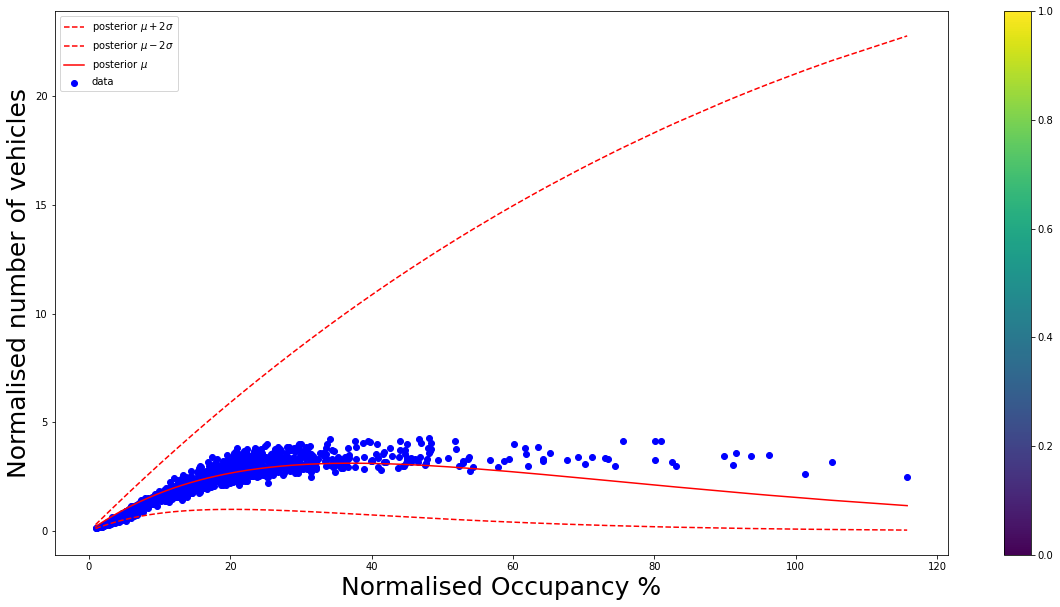

In [315]:
plt.figure(figsize=(20,10))
plt.scatter(rho,q,label='data',color='blue')
plt.plot(rho,q_hat_upper_bound,label=r'posterior $\mu+2\sigma$',color='red',linestyle='dashed')
plt.plot(rho,q_hat_lower_bound,label=r'posterior $\mu-2\sigma$',color='red',linestyle='dashed')
plt.plot(rho,q_hat_mean,label=r'posterior $\mu$',color='red')
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Occupancy %',fontsize=25)
plt.colorbar()
plt.legend()

if export_data: plt.savefig(base_url+method+'/'+filename+'_data_fit.png')

### Export data

In [74]:
# Flag for exporting data
export_data = False

In [75]:
if export_data:
    # Export MCMC chains
    np.savetxt(base_url+method+'/'+filename+'.txt',grw_mcmc_parameters)
    
    # Compile metadata
    grw_posterior_metadata = {}
    grw_posterior_metadata['acceptance'] = grw_mcmc_acceptance
    grw_posterior_metadata['gelman_rubin_statistic'] = grw_mcmc_gelman_rubin_statistic
    grw_posterior_metadata['log_marginal_likelihood'] = exponential_fd_lml
    grw_posterior_metadata['N'] = N
    grw_posterior_metadata['beta_step'] = beta_step
    grw_posterior_metadata['beta_prior_alpha_param'] = {'a':beta_prior_a_alpha_param,'b':beta_prior_b_alpha_param}
    grw_posterior_metadata['beta_prior_beta_param'] = {'a':beta_prior_a_beta_param,'b':beta_prior_b_beta_param}
    grw_posterior_metadata['gamma_prior_sigma_param'] = {'a':gamma_prior_a_sigma_param,'b':gamma_prior_b_sigma_param}
    grw_posterior_metadata['initial_parameters'] = list(parameters_init)
    grw_posterior_metadata['prior_variances'] = list(np.diag(prior_covariance))

    # Export metadata
#     print(json.dumps(grw_posterior_metadata,indent=2))

    with open(base_url+method+'/'+filename+'_metadata.json', 'w') as outfile:
        json.dump(grw_posterior_metadata, outfile)

# preconditioned Crack Nicholson

In [ ]:
# Define inference method
method = 'pcn_mcmcm'

In [59]:
def pcn(log_likelihood, _p0, _sigma2, _y, _K, _N, _beta):
    """ pCN MCMC method for sampling from pdf defined by log_likelihood.
    Inputs:
        log_likelihood - log-likelihood function
        _p0 - initial sample
        _y - observed data
        _sigma2 - prior variance
        _N - number of samples
        _beta - step-size parameter
    Returns:
        _theta - samples from target distribution
        acc/n_iters - the proportion of accepted samples"""

    _theta = []
    acc = 0
    p_prev = copy.deepcopy(_p0)
    _n0 = p_prev.shape[0]
    
    for i in tqdm(range(_N)):

        ll_prev = log_likelihood(p_prev, _y, _sigma2)

        # Propose new sample using pCN proposal
        p_new = np.sqrt(1-pow(_beta,2))*p_prev + _beta*scipy.stats.multivariate_normal.rvs(np.zeros(_n0), _K)
        
        ll_new = log_likelihood(p_new, _y, _sigma2)
        
        # TODO: Calculate pCN acceptance probability
        log_acc = ll_new - ll_prev
        log_u = np.log(np.random.random())
        
        
        
        # Accept/Reject
        # TCompare log_alpha and log_u to accept/reject sample
        if min(np.exp(log_acc),1) >= np.exp(log_u):
            acc += 1
            _theta.append(p_new)
            p_prev = p_new
        else:
            _theta.append(p_prev)

    return np.array(_theta), acc / _N

## Population MCMC

### Define key functions

In [ ]:
# Uniform geometric-based temperature schedule
def uniform_t(_n):
    return np.array([i/_n for i in range(_n+1)]).reshape((_n+1,1))

# Prior geometric-based temperature schedule
def prior_t(_n,_p):
    return np.array([(i/_n)**_p for i in range(_n+1)]).reshape((_n+1,1))

# Posterior geometric-based temperature schedule
def posterior_t(_n,_p):
    return np.array([(1-(i/_n)**_p) for i in range(_n+1)]).reshape((_n+1,1))

def exponential_fd_log_prior_t(p,t):
    return np.sum([ss.beta.logpdf(p[t,i],prior_alpha,prior_beta) for i in range(num_params)])

def exponential_fd_log_likelihood_t(p,t,y,sigma_2):
    return ss.multivariate_normal.logpdf(y,exponential_fd(p[t,:]),np.eye(y.shape[0])*sigma_2)

def exponential_fd_log_target_t(p,y,temp,t,sigma_2):
    # Log target is sum of priors and likelihood for each temperature
    return log_exponential_fd_prior_t(p,t) + temp[t]*log_exponential_fd_likelihood_t(p,t,y,sigma_2)

def gaussian_transition_kernel_t(p_prev,cov):
    # Propose move
    p_new = p_prev + np.random.multivariate_normal(np.zeros(p_prev.shape[0]),cov)

    # Reflect off boundaries
    for j in range(num_params):
        if p_new[j] < 0.:
            p_new[j] = -p_new[j]
        if p_new[j] > 1.:
            p_new[j] = 1. - (p_new[j] - 1.)
    return p_new
    

def gaussian_transition_kernel_density_t(p_prev,p_new,t,sigma_2):
    return ss.multivariate_normal.logpdf(p_new[t,:],p_prev[t,:],np.eye(num_params)*sigma_2)

def exponential_fd_log_mutation_mh_acceptance_ratio_t(p_prev,p_new,t,y,temp,sigma_2):
    numerator = exponential_fd_log_prior(p_new,t) + temp[t]*exponential_fd_log_likelihood(p_new,t,y,sigma_2) #+ gaussian_transition_kernel_density(p_new,p_prev,t,sigma_2)
    denominator =  exponential_fd_log_prior(p_prev,t) + temp[t]*exponential_fd_log_likelihood(p_prev,t,y,sigma_2) #+ gaussian_transition_kernel_density(p_prev,p_new,t,sigma_2)
    return numerator - denominator

def exponential_fd_log_exchange_mh_acceptance_ratio_t(p_prev,p_new,ti,tj,y,temp,sigma_2):
    numerator = temp[ti]*exponential_fd_log_likelihood(p_new,ti,y,sigma_2)\
                + temp[tj]*exponential_fd_log_likelihood(p_new,tj,y,sigma_2)
#                 + gaussian_transition_kernel_density(p_new,p_prev,ti,sigma_2)\
#                 + gaussian_transition_kernel_density(p_new,p_prev,tj,sigma_2)
    denominator = temp[ti]*exponential_fd_log_likelihood(p_prev,ti,y,sigma_2)\
                  + temp[tj]*exponential_fd_log_likelihood(p_prev,tj,y,sigma_2)
#                   + gaussian_transition_kernel_density(p_prev,p_new,ti,sigma_2)\
#                   + gaussian_transition_kernel_density(p_prev,p_new,tj,sigma_2)
    return numerator - denominator


In [ ]:
def population_mcmc(kernel,temp_schedule,init_params,y,transition_cov,sigma_2,n_iterations,p_mutation,seed=None,print_stat:bool=False):
    
    # Fix random seed
    np.random.seed(seed)
    
    # Store length of temperature schedule
    t_len = temp_schedule.shape[0]
    
    # Initialise sample array
    theta = np.zeros((n_iterations,t_len,init_params.shape[1]))
    
    # Initiliase acceptance rate and proposal counter for mutation and crossover
    prop = np.zeros(3) # 0: mutation, 1: crossover, 2: exchange
    acc = np.zeros(3)
    
    # Define parameter initialisation
    theta_prev = init_params
    
    for ni in tqdm(range(n_iterations)):
        # Randomly pick between local and crossover move
        if np.random.uniform(0,1,1) <= p_mutation:
            # Local mutation move
            prop[0] += 1
            
            # Select random temperature from schedule
            random_t_index = random.choice(range(0,t_len))
            
            # Propose local mutation move
            theta_new = copy.deepcopy(theta_prev)
            theta_new[random_t_index,:] = kernel(theta_prev[random_t_index,:],transition_cov)
            if print_stat: 
                print(f'mutation at {random_t_index}')
                print('theta_prev',theta_prev[random_t_index,:])
                print('theta_new',theta_new[random_t_index,:])
            
            # Compute log Metropolis Hasting acceptance ratio for mutation
            log_mutation_acc_ratio = exponential_fd_log_mutation_mh_acceptance_ratio_t(theta_prev,theta_new,random_t_index,y,temp_schedule,sigma_2)
        
            if print_stat: print('mutation acceptance ratio',min(np.exp(log_mutation_acc_ratio),1))
#             print('mutation_acc_ratio',np.exp(log_mutation_acc_ratio))

            # Accept/reject local mutation proposal
            if min(np.exp(log_mutation_acc_ratio),1) >= np.random.uniform(0,1,1):
                # Accept
                theta_prev = theta_new
                acc[0] += 1
                if print_stat: print('accepted mutation',theta_new)
                
        else:
            # Crossover move
            prop[1] += 1
            
            # Randomly select two chains indices
            random_t_index_i = random.choice(range(0,t_len))
            random_t_index_j = random.choice(range(0,t_len))
            
            # Randomly select crossover point
            c = random.choice(range(0,num_params)) # Paper suggests num_params-1 instead of num_params
            
            # Perform crossover move
            theta_new = copy.deepcopy(theta_prev)
            theta_new[random_t_index_i,c:] = theta_prev[random_t_index_j,c:]
            theta_new[random_t_index_j,c:] = theta_prev[random_t_index_i,c:]
    
            if print_stat:  print(f'Crossover between {random_t_index_i} and {random_t_index_j} at point {c}')

            # Compute log Metropolis Hasting acceptance ratio for crossover
            log_crossover_acc_ratio = exponential_fd_log_exchange_mh_acceptance_ratio_t(theta_prev,theta_new,random_t_index_i,random_t_index_j,y,temp_schedule,sigma_2)

            if print_stat:  print('crossover acceptance ratio',min(np.exp(log_crossover_acc_ratio),1))

            # Accept/reject crossover proposal
            if min(np.exp(log_crossover_acc_ratio),1) >= np.random.uniform(0,1,1):
                # Accept
                theta_prev = theta_new
                acc[1] += 1
                if print_stat: print('accepted crossover',theta_new)
                
        
        # Global exchange move
        prop[2] += 1
        
        # Randomly select a chains index
        random_t_index = random.choice(range(0,t_len))
        # Get adjacent chain
        exchange_t_index = random_t_index + 1
        # If current chain is the last then select the first chain as adjacent
        if random_t_index == t_len-1:
            exchange_t_index = 0
        
        # Perform global exchange move
        theta_new = copy.deepcopy(theta_prev)
        theta_new[random_t_index,:] = theta_prev[exchange_t_index,:]
        theta_new[exchange_t_index,:] = theta_prev[random_t_index,:]

        if print_stat:  print(f'Exchange between {random_t_index} and {exchange_t_index}')
#         print(f'Exchange between {random_t_index} and {exchange_t_index}')
        
#         print('theta_prev == theta_new',theta_prev == theta_new)
    
        # Compute log Metropolis Hasting acceptance ratio for crossover
        log_exchange_acc_ratio = exponential_fd_log_exchange_mh_acceptance_ratio_t(theta_prev,theta_new,random_t_index,exchange_t_index,y,temp_schedule,sigma_2)

        if print_stat:  print('exchange acceptance ratio',min(np.exp(log_exchange_acc_ratio),1))
#         print('exchange acceptance ratio',np.exp(log_exchange_acc_ratio))

        # Accept/reject exchange proposal
        if min(np.exp(log_exchange_acc_ratio),1) >= np.random.uniform(0,1,1):
            # Accept
            theta_prev = theta_new
            acc[2] += 1
            if print_stat: print('accepted exchange',theta_new)
        
        
        # Append sample to array
        theta[ni,:,:] = theta_prev
            
    
    return theta, np.divide(acc,prop)

In [ ]:
# Fix random seed
np.random.seed(2021)

# Define power
p = 5
# Define number of parameters
num_params = 2
# Define parameter names
param_names = [r'$\alpha$',r'$\beta$']
# Define number of disretisations of [0,1] interval
n = 20
# Define number of iterations of each temperature chain
N = 1000
# Define observation variance
sigma2 = 2
# Define transition kernel variance
transition_cov = np.diag([0.1,0.01])
# Prior alpha for parameters
prior_alpha = 1
# Prior beta for parameters
prior_beta = 2
# Set mutation probability for proposing local move instead of crossover move
pm = 1
# Define temperature schedule
temperature_schedule = prior_t(n,p)

# Generate pairs of (alpha,beta) from Beta(1,2) prior
parameters_init = np.zeros((n+1,num_params))
parameters_init[:,0] = np.array([a for a in np.random.beta(prior_alpha,prior_beta,n+1)])
parameters_init[:,1] = np.array([b for b in np.random.beta(prior_alpha,prior_beta,n+1)])

In [ ]:
# pop_mcmc_parameters,pop_mcmc_acceptances = population_mcmc(gaussian_transition_kernel_t,temperature_schedule,parameters_init,q,transition_cov,sigma2,N,pm)

print('Population MCMC')
print(f'Mutation acceptance rate {int(pop_mcmc_acceptances[0]*100)}%')
if pm < 1:
    print(f'Crossover acceptance rate {int(pop_mcmc_acceptances[1]*100)}%')
print(f'Exchange acceptance rate {int(pop_mcmc_acceptances[2]*100)}%')

## Inspect samples 

In [ ]:
# Find index of largest temperature (corresponding to posterior measure)
highest_temp_idx = np.argmax(temperature_schedule)

# Select temperature to inspect samples for
temp_choice = highest_temp_idx

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=num_params,figsize=(30,10))

for i in range(1,num_params+1):
    plt.subplot(1,num_params,i)
    plt.title(f'{param_names[i-1]} parameter, t = {prior_t(n,p)[temp_choice][0]}',fontsize=25)
    plt.plot(range(1,N+1),pop_mcmc_parameters[:,temp_choice,i-1],label='Sampled chains')
    plt.ylabel('Parameter samples',fontsize=25)
    plt.xlabel('Population MCMC iteration',fontsize=25)
#     plt.legend(fontsize=20)


# Compute log marginal likelihood

The log marginal likelihood is equal to 

$$\log(Z_t) = \sum_{i=1}^n \log(Z_{t_{i}})$$

and is calculated from

$$\log(p(\mathbf{y})) = \lim_{\Delta t \to 0} \sum_{i=1}^n  \mathbb{E}_{\theta|\mathbf{y},t_i}\left[\log(p(\mathbf{y}|\theta)\right] \Delta t \approx  \sum_{i=1}^n \sum_{j=1}^N \log(p(\mathbf{y}|\theta_i^{(j)}) \Delta t$$

where $\theta_i^{(j)}$ are samples from the population MCMC-inferred posterior $p(\theta|\mathbf{y},t_i)$.


In [ ]:
def exponential_fd_log_marginal_likelihood(learned_params,y,temp_schedule,sigma_2):
    
    # Store length of temperature schedule
    t_len = temp_schedule.shape[0]
    
    # Get number of MCMC iterations
    num_iters = learned_params.shape[0]
    
    # Initiliase lml 
    lml = 0    
#     return np.sum([(temp_schedule[ti] - temp_schedule[ti-1]) * np.sum([exponential_fd_log_likelihood(learned_params[j,:,:],ti,y,sigma_2) for ti in range(1,t_len) for j in range(num_iters)])])
    
    # Loop temperature indices
    for ti in tqdm(range(1,t_len)):
        # Compute Delta t
        delta_t = temp_schedule[ti] - temp_schedule[ti-1]
        
        # Loop through each iteration
        for j in range(num_iters):
            # Compute posterior expectation
            lml += delta_t * exponential_fd_log_likelihood(learned_params[j,:,:],ti,y,sigma_2)
    
    return lml

In [ ]:
exponential_fd_lml = exponential_fd_log_marginal_likelihood(pop_mcmc_parameters,q,temperature_schedule,sigma2)

In [ ]:
exponential_fd_lml